# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: Freezing weights during learning
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

# # normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# import dataset from torchvision
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()

print(dataNorm.shape)
print(labels.shape)

torch.Size([70000, 784])
torch.Size([70000])


In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_3572/4159625118.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( dataNorm ).float()
/tmp/ipykernel_3572/4159625118.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).long()


# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Brief inspection of requires_grad

In [5]:
# inspect the "learning toggle" of a layer
N = createTheMNISTNet()[0]
N.fc1.weight.requires_grad

True

In [6]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False
  

# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


# Create a function that trains the model

In [19]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):



    
    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True
    
    # for p in net.named_parameters():
    #   if 'fc1' in p[0]:
    #     p[1].requires_grad = False
    



    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Let's see it in action!

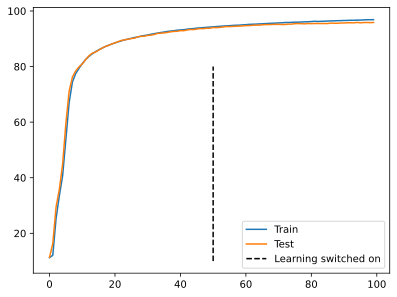

In [20]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()

# Additional explorations

In [ ]:
# 1) Switch off all the weights, but leave all the biases switched on. Can the model still learn (at least, better than 
#    chance level)? Then do the opposite: let the weights learn but turn off learnign in the biases. How does the model
#    perform now, and what does this tell you about weights vs. biases?
#
#    With the bias on, the learning will be smaller than with the weights on. Weight is more important than bias.
#    With the bias on it doesn't learn. With the weight on it learns a little bit more, but still not a lot.
#    It feels like the bias helps the weight to keep more stable, but the weight is the one that actually learns.
#    In general, the good idea is to keep both on.
# 
# 2) Freeze only one layer, e.g., layer fc1 (freeze both the weights and biases). Store the accuracy output as a separate
#    variable, so you run the network again without freezing anything. Then plot the accuracies (with and without 
#    freezing) on the same graph. How important is fc1 based on this plot?
#
#    fc1 should be pretty important, as it's 25% of the layers (input, fc1, fc2 and output). Being also the first 
#    hidden layer, I expect it to be quite important. In any case, I expect the model to keep learning even with
#    fc1 frozen. (In the same way that I would expect a model with only a hidden layer to work, even if it's not as good)
#    In the end, the performance was very similar. With the frozen layer it went a little bit slower, but it still learned.
# 